In [17]:
import pandas as pd 

In [18]:
import wandb
api = wandb.Api()
runs = api.runs("wuzhengx/fine_tuning")
eval_metrics = {
    "sst3":"eval/Macro-F1",
    "mrpc":"eval/accuracy",
    "qnli":"eval/accuracy",
}

#### Performance analysis for syntactic shifts

In [19]:
task_name = "sst3" # please change to the task you are analyzing.

In [39]:
all_data = []
for run in runs:
    if task_name in run.name:
        perf_metrics = run.history(keys=[eval_metrics[task_name]])[eval_metrics[task_name]]
        best_perf_metrics = max(perf_metrics)
        run_name = run.name
        
        name_list = run_name.split("_")
        learning_rate_found = False
        data_found = False
        reverse_found = False
        random_found = False
        inoculation_found = False
        seed_found = False
        for i in range(len(name_list)):
            if name_list[i] == "lr":
                learning_rate_found = True
                learning_rate = name_list[i+1]

            if name_list[i] == "seed":
                seed_found = True
                seed = int(name_list[i+1])
            if name_list[i] == "reverse":
                reverse_found = True
                if name_list[i+1] == "True":
                    reverse_order = True
                else:
                    reverse_order = False
            if name_list[i] == "random":
                random_found = True
                if name_list[i+1].strip("/") == "True":
                    random_order = True
                else:
                    random_order = False
            if name_list[i] == "data":
                data_found = True
                if len(name_list[i+1].split("-")) > 2:
                    perturbed_type = name_list[i+1].split("-")[2:][0]
                else:
                    perturbed_type = "null"
            if name_list[i] == "inoculation":
                inoculation_found = True
                inoculation_p = float(name_list[i+1])
        # if underspecify, we just replace with default values.
        if not learning_rate_found:
            learning_rate = "2e-05"
        if not data_found:
            perturbed_type = "null"
        if not reverse_found:
            reverse_order = False
        if not random_found:
            random_order = False
        if not inoculation_found:
            inoculation_p = 0.0
        if not seed_found:
            seed = 42
        if inoculation_p == 0.0 or inoculation_p == 1.0:            
            if perturbed_type != "null":
                all_data.append([perturbed_type, reverse_order, random_order, inoculation_p, learning_rate, seed, best_perf_metrics])
            else:
                if "token_s_True" in run_name or "reinit_emb_True" in run_name or "word_s_True" in run_name:
                    # these conditions cannot be considered.
                    continue
                if "reverse_True" in run_name or "random_True" in run_name:
                    all_data.append(["null", reverse_order, random_order, 0.0, learning_rate, seed, best_perf_metrics])
                else:
                    # we may need to record if this is some baseline.
                    if "roberta-base_reinit_emb_False_reinit_avg_False_token_s_False_word_s_False" in run_name:
                        all_data.append(["null", False, False, 0.0, learning_rate, seed, best_perf_metrics])
                    if "roberta-base_roberta-base_seed_42_data_wikitext-15M_inoculation_0.0_reverse_False_random_False" in run_name:
                        all_data.append(["null", False, False, 0.0, learning_rate, seed, best_perf_metrics])
                    if "roberta-base_roberta-base_seed_42_data_wikitext-15M_inoculation_1.0_reverse_False_random_False" in run_name:
                        all_data.append(["null", False, False, 1.0, learning_rate, seed, best_perf_metrics])

In [40]:
df = pd.DataFrame(
    all_data, 
    columns = ['perturbed_type','reverse_order','random_order', 'inoculation_p', "lr", 'seed', 'best_perf_metrics']
)

In [94]:
learning_rate = 8e-05
inoculation_p = 0.0

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match Dat

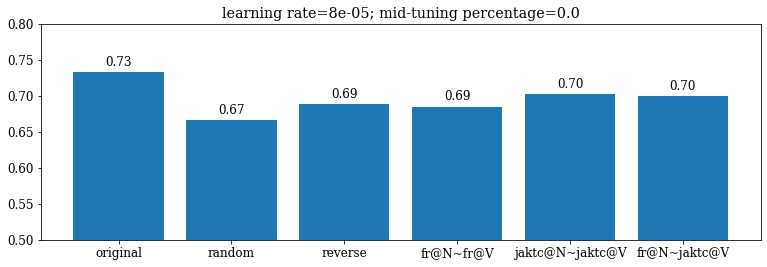

In [95]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_axes([0,0,1,1])

    # different learning rate
    lr_select = df[(df["lr"]==f"{learning_rate}")&(df["inoculation_p"]==inoculation_p)]
    legends = ["original", "random", "reverse", "fr@N~fr@V", "jaktc@N~jaktc@V", "fr@N~jaktc@V"]
    data = [
        lr_select[(df["perturbed_type"]=="null")&(df["reverse_order"]==False)&(df["random_order"]==False)]["best_perf_metrics"].values[0],
        lr_select[(df["perturbed_type"]=="null")&(df["reverse_order"]==False)&(df["random_order"]==True)]["best_perf_metrics"].values[0],
        lr_select[(df["perturbed_type"]=="null")&(df["reverse_order"]==True)&(df["random_order"]==False)]["best_perf_metrics"].values[0],
        lr_select[(df["perturbed_type"]=="en~fr@N~fr@V")&(df["reverse_order"]==False)&(df["random_order"]==False)]["best_perf_metrics"].values[0],
        lr_select[(df["perturbed_type"]=="en~jaktc@N~jaktc@V")&(df["reverse_order"]==False)&(df["random_order"]==False)]["best_perf_metrics"].values[0],
        lr_select[(df["perturbed_type"]=="en~fr@N~jaktc@V")&(df["reverse_order"]==False)&(df["random_order"]==False)]["best_perf_metrics"].values[0],
    ]
    bars = ax.bar(legends, data)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval+.005, "%.2f"%yval, ha='center', va='bottom')
    ax.set_facecolor("white")
    plt.title(f"learning rate={learning_rate}; mid-tuning percentage={inoculation_p}")
    plt.ylim(0.5, 0.8)
    plt.show()
    # plt.savefig("../../data-files-updated/Analysis-Result/action_sequence_length",dpi=1000, bbox_inches='tight')

#### Performance analysis for tokenization

In [145]:
def fetch_data(task_name):
    all_data = []
    tokenizer_combo = ["roberta-base_albert-base-v2", "roberta-base_bert-base-cased"]
    for run in runs:
        if task_name in run.name:
            perf_metrics = run.history(keys=[eval_metrics[task_name]])[eval_metrics[task_name]]
            best_perf_metrics = max(perf_metrics)
            run_name = run.name
            is_valid = False
            for t in tokenizer_combo:
                if t in run_name:
                    if "NEED RERUN" not in run_name and "9-6" not in run_name:
                        is_valid = True
                        break
            
            if is_valid:
                name_list = run_name.split("_")
                exam_1 = False
                exam_2 = False
                exam_3 = False
                learning_rate = "2e-05"
                for i in range(len(name_list)):
                    if name_list[i] == "seed":
                        seed = int(name_list[i+1])
                    if name_list[i] == "reinit" and name_list[i+1] == "emb" and not exam_1:
                        exam_1 = True
                        if name_list[i+2] == "True":
                            reinit_random = True
                        else:
                            reinit_random = False
                    if name_list[i] == "reinit" and name_list[i+1] == "avg" and not exam_2:
                        exam_2 = True
                        if name_list[i+2].strip("/") == "True":
                            reinit_avg = True
                        else:
                            reinit_avg = False
                    if name_list[i] == "data":
                        if len(name_list[i+1].split("-")) > 2:
                            perturbed_type = "-".join(name_list[i+1].split("-")[2:])
                        else:
                            perturbed_type = "null"
                    if name_list[i] == "inoculation":
                        inoculation_p = float(name_list[i+1])
                    if name_list[i] == "lr":
                        learning_rate = float(name_list[i+1])
                model_type = name_list[4]
                tokenizer_type = name_list[5]
                all_data.append([model_type, tokenizer_type, True, reinit_avg, inoculation_p, learning_rate, seed, best_perf_metrics])

            # maybe it is other baselines?
            if "finetune_roberta-base_reinit_emb_True_reinit_avg_False" in run_name and "9-7" not in run_name and "9-8" not in run_name:
                name_list = run_name.split("_")
                learning_rate = "2e-05"
                for i in range(len(name_list)):
                    if name_list[i] == "lr":
                        learning_rate = float(name_list[i+1])
                all_data.append(["roberta-base", "roberta-base", True, False, 0.0, learning_rate, 42, best_perf_metrics])
#             if "finetune_roberta-base_roberta-base_seed_42_data_wikitext-15M_inoculation_1.0_reverse_False_random_False_reinit_emb_True_reinit_avg_False_reinit_emb_False_reinit_avg_False" in run_name:
#                 all_data.append(["roberta-base", "roberta-base", True, False, 1.0, 42, best_perf_metrics])
    return all_data

In [158]:
task_name = "mrpc" # please change to the task you are analyzing.

In [159]:
all_data = fetch_data(task_name)

In [160]:
df = pd.DataFrame(
    all_data, 
    columns = ['model_type', 'tokenizer_type', 'reinit_random','reinit_avg', 'inoculation_p', 'lr', 'seed', 'best_perf_metrics']
).sort_values("tokenizer_type")

In [161]:
df

,model_type,tokenizer_type,reinit_random,reinit_avg,inoculation_p,lr,seed,best_perf_metrics
0,roberta-base,albert-base-v2,True,False,0.0,8e-05,42,0.683824
2,roberta-base,albert-base-v2,True,False,1.0,2e-05,42,0.806373
6,roberta-base,albert-base-v2,True,False,0.0,2e-05,42,0.718137
1,roberta-base,bert-base-cased,True,False,0.0,8e-05,42,0.683824
3,roberta-base,bert-base-cased,True,False,1.0,2e-05,42,0.823529
5,roberta-base,bert-base-cased,True,False,0.0,2e-05,42,0.703431
4,roberta-base,roberta-base,True,False,0.0,2e-05,42,0.683824


#### Performance analysis for morphology

In [3]:
def fetch_data(task_name):
    all_data = []
    for run in runs:
        if task_name in run.name:
            run_name = run.name
            perf_metrics = run.history(keys=[eval_metrics[task_name]])[eval_metrics[task_name]]
            best_perf_metrics = max(perf_metrics)
            if "token_s_True" in run_name or "word_s_True" in run_name:
                name_list = run_name.split("_")
                learning_rate = "2e-05"
                inoculation_p = 0.0
                seed_found = False
                
                for i in range(len(name_list)):
                    if name_list[i] == "seed":
                        seed_found = True
                        seed = int(name_list[i+1])
                    if name_list[i] == "inoculation":
                        inoculation_p = float(name_list[i+1])
                    if name_list[i] == "lr":
                        learning_rate = float(name_list[i+1])
                token_s = False
                word_s = False
                if "token_s_True" in run_name:
                    token_s = True
                if "word_s_True" in run_name:
                    word_s = True
                if not seed_found:
                    seed = 42
                all_data.append(["roberta-base", token_s, word_s, inoculation_p, learning_rate, seed, best_perf_metrics])
    return all_data

In [4]:
all_data = fetch_data("mrpc")

In [5]:
df = pd.DataFrame(
    all_data, 
    columns = ['model_type', 'token_swap', 'word_swap', 'inoculation_p', 'lr', 'seed', 'best_perf_metrics']
)

In [6]:
df

,model_type,token_swap,word_swap,inoculation_p,lr,seed,best_perf_metrics
0,roberta-base,True,False,0.0,8e-05,42,0.683824
1,roberta-base,False,True,0.0,8e-05,42,0.779412
2,roberta-base,True,False,1.0,2e-05,42,0.845588
3,roberta-base,False,True,1.0,2e-05,42,0.786765
4,roberta-base,False,True,0.0,2e-05,42,0.781863
5,roberta-base,True,False,0.0,2e-05,42,0.784314
